In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ahrs
from numpy.linalg import norm
import scipy


In [104]:
PATH_TO_DATA = "./data/"

imu = pd.read_csv(PATH_TO_DATA + "set1_imu.csv", encoding="utf-8")
tab = pd.read_csv(PATH_TO_DATA + "set1_tab.csv", encoding="utf-16")

imu = pd.read_csv(PATH_TO_DATA + "position_data_imu.csv", encoding="utf-16")
tab = pd.read_csv(PATH_TO_DATA + "position_data_tab.csv", encoding="utf-8")

In [105]:
imu.head()

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
0,361742653357600,172291,-1.1210,-4.3585,-8.0758,1.2511,-0.0709,0.1845,20.37
1,361742664144600,172302,-1.0469,-4.3597,-8.0219,1.0116,-0.0733,0.1185,20.37
2,361742676191700,172313,-1.0277,-4.3155,-7.9095,0.8711,-0.0770,0.0134,20.37
3,361742687385900,172324,-0.9775,-4.2461,-7.7707,0.6536,-0.0648,-0.0843,20.37
4,361742698424000,172336,-0.9392,-4.7151,-7.9406,0.3079,-0.0354,-0.1429,20.36


In [106]:
imu["arduino_timestamp"] = (imu["arduino_timestamp"] - np.min(imu["arduino_timestamp"])) * 0.001

imu = imu[5400:7000]

In [107]:
#from sklearn.preprocessing import MinMaxScaler
#for col in ["ax", "ay", "az"]:
			#scaler = MinMaxScaler().fit(imu[[col]])
			#imu[col] = scaler.transform(imu[[col]])

from sklearn.preprocessing import normalize
imu[["ax", "ay", "az"]] = normalize(imu[["ax", "ay", "az"]], axis=1, norm='l2')

In [108]:
imu.head()

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
5400,361803587178800,60.932,-0.933751,0.061181,-0.352655,-0.4398,0.6292,-0.0281,20.86
5401,361803598223400,60.943,-0.921086,0.074503,-0.382164,-0.4789,0.6426,0.1283,20.81
5402,361803609384800,60.954,-0.907408,0.082943,-0.411984,-0.4459,0.5840,0.2175,20.81
5403,361803620183100,60.965,-0.909824,0.114454,-0.398899,-0.3494,0.5510,0.1943,20.84
5404,361803632046100,60.977,-0.909486,0.125909,-0.396210,-0.3409,0.5107,0.1698,20.84


In [109]:
madgwick = ahrs.filters.Madgwick()


Guess the initial position from acceleration data.
We define:   

$R (q_{E}^{S}) \ \begin{pmatrix}0\\0\\1\end{pmatrix}= \begin{pmatrix}a_{x}\\a_{y}\\a{z}\end{pmatrix}$

Where $R (q_{E}^{S})$ is the rotation matrix from the global frame to the sensor frame.
Using the rotation matrix as defined in "Keeping a Good Attitude: A Quaternion-Based Orientation Filter for IMUs and MARGs" we can the equation (25), keeping in mind that the function is not continous at point $a_{z} = 0$

In [110]:
def intial_or(ax,ay,az):
    if az >= 0:
        q0 = np.sqrt((az+1)/2)
        q1 = - ay/ np.sqrt((az+1)*2)
        q2 = ax/ np.sqrt((az+1)*2)
        q3 = 0
    else:
        q0 = - ay/ np.sqrt((1-az)*2)
        q1 = np.sqrt((1-az)/2)
        q2 = 0
        q3 = ax/ np.sqrt((1-az)*2)
    return [q0,q1,q2,q3]

In [111]:
# compare both intial orientation estimation approaches
A = imu[["ax", "ay", "az"]].values
i1 = ahrs.common.orientation.acc2q(A[0]) 
i2 = intial_or(A[0,0], A[0,1], A[0,2])
print(i1,i2)

[ 0.07068442  0.82095369  0.04860488 -0.56451423] [-0.03719699647997001, 0.8223912707848302, 0, -0.5677050124754768]


In [112]:
T = imu["arduino_timestamp"].values
A = imu[["ax", "ay", "az"]].values
G = imu[["gx", "gy", "gz"]].values
Q = np.zeros((len(T), 4))
Q[0] = ahrs.common.orientation.acc2q(A[0]) #intial_or(A[0,0], A[0,1], A[0,2])
for i in range(1, len(T)):
    madgwick.Dt = (T[i] - T[i - 1]) 
    Q[i] = madgwick.updateIMU(Q[i - 1], G[i], A[i])
imu = pd.concat([imu.reset_index(drop=True), pd.DataFrame(Q, columns=['q0','q1','q2','q3'])], axis=1)


In [113]:
imu[["q0","q1","q2","q3"]].head()

,q0,q1,q2,q3
0,0.073138,0.822936,0.049706,-0.561210
1,0.075714,0.824762,0.050289,-0.558128
2,0.077927,0.826474,0.050574,-0.555258
3,0.080279,0.828165,0.050927,-0.552362
4,0.082123,0.829779,0.051539,-0.549605


In [114]:
def rotation_matrix(q):
    """
    Input:
        Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 

    Output:
        3x3 rotation matrix. 
        This rotation matrix converts a point in the local reference 
        frame to a point in the navigation reference frame.
    """

    # divide by norm so we have a unit quaternion
    q0 = q[0] / norm(q)
    q1 = q[1] / norm(q)
    q2 = q[2] / norm(q)
    q3 = q[3] / norm(q)

    R = np.zeros((3,3))
    
    R[0,0] = 1- 2 * (q2 * q2 + q3 * q3) 
    R[0,1] = 2 * (q1 * q2 - q0 * q3)
    R[0,2] = 2 * (q1 * q3 + q0 * q2)
    
    R[1,0] = 2 * (q1 * q2 + q0 * q3)
    R[1,1] = 1 - 2 * (q1 * q1 + q3 * q3) 
    R[1,2] = 2 * (q2 * q3 - q0 * q1)
    
    R[2,0] = 2 * (q1 * q3 - q0 * q2)
    R[2,1] = 2 * (q2 * q3 + q0 * q1)
    R[2,2] = 1 - 2 * (q1 * q1 + q2 * q2) 

    # inverse of R is body to global, matrix is orthogonal so transpose is equal to inverse                  
    return np.transpose(R)

In [115]:
imu['R_b_g'] = imu.apply(lambda row: rotation_matrix([row.q0, row.q1, row.q2, row.q3]), axis=1)

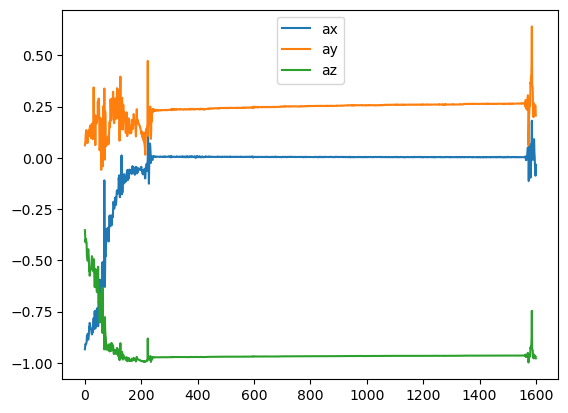

In [116]:
plt.plot(imu.loc[:, "ax"], label="ax")
plt.plot(imu.loc[:, "ay"],label ="ay")
plt.plot(imu.loc[:, "az"], label= "az")
plt.legend()

If we want to handle the gravity we have to substract $\begin{pmatrix}0\\0\\1 \end{pmatrix} $. However, since we are not holding the pen perfectly aligned to one of the axes we will in each step use the rotation matrix to transform the gravity vector which is given in the global frame to the body frame and then substract from the acceleration also measured in the body frame.

In [117]:
def nav_g(R: np.ndarray):
        nav_g = R.T @ [0,0,1]
        return nav_g 
imu[["nav_g_x","nav_g_y","nav_g_z"]] = imu.apply(lambda row: pd.Series(nav_g(row.R_b_g)), axis=1) 

In [118]:
imu[["nav_g_x","nav_g_y","nav_g_z"]].head()

,nav_g_x,nav_g_y,nav_g_z
0,-0.916409,-0.176167,-0.359389
1,-0.913030,-0.181027,-0.365521
2,-0.909929,-0.184972,-0.371233
3,-0.906718,-0.189228,-0.376902
4,-0.903637,-0.192941,-0.382380


In [119]:
imu["fixed_ax"] = imu.apply(lambda row: pd.Series(row.ax - row.nav_g_x), axis=1) 
imu["fixed_ay"] = imu.apply(lambda row: pd.Series(row.ay - row.nav_g_y), axis=1) 
imu["fixed_az"] = imu.apply(lambda row: pd.Series(row.az - row.nav_g_z), axis=1) 

imu[["fixed_ax", "fixed_ay", "fixded_az"]] = normalize(imu[["fixed_ax", "fixed_ay", "fixed_az"]], axis=1, norm='l2')

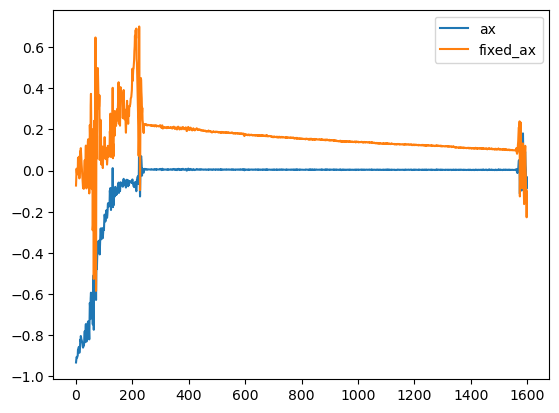

In [120]:
plt.plot(imu.loc[:, "ax"], label="ax")
plt.plot(imu.loc[:, "fixed_ax"],label ="fixed_ax")
plt.legend()

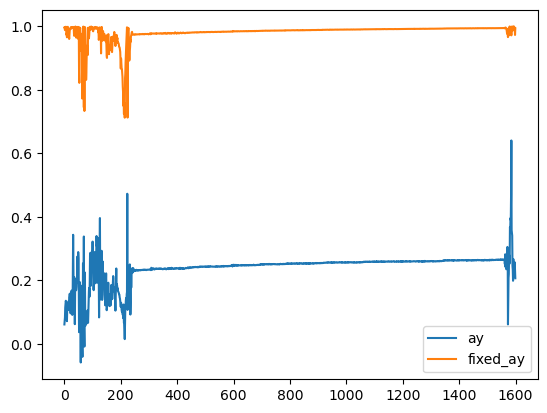

In [121]:
plt.plot(imu.loc[:, "ay"], label="ay")
plt.plot(imu.loc[:, "fixed_ay"],label ="fixed_ay")
plt.legend()

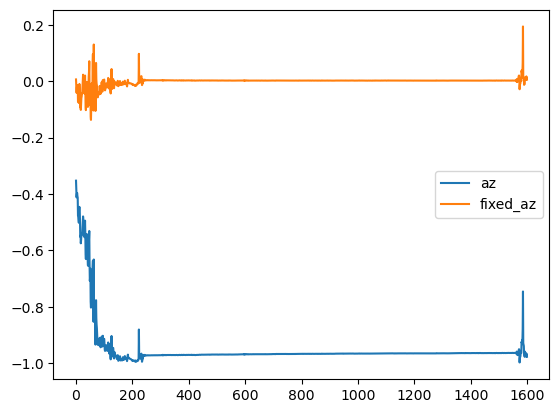

In [122]:
plt.plot(imu.loc[:, "az"], label="az")
plt.plot(imu.loc[:, "fixed_az"],label ="fixed_az")
plt.legend()